<a href="https://colab.research.google.com/github/gabrielealberto/Binomial-Asset-Pricer/blob/main/Binomial_Asset_Pricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
"""
Binomial Option Pricing (European & American)

Calculates Call and Put prices using a discrete binomial tree.
Supports European ("eu") and American ("am") options.

Key variables:
- index       : ticker symbol of the underlying asset
- opttype     : 'c' for call, 'p' for put
- option_style: 'eu' for European, 'am' for American
- s0          : current price of the underlying
- k           : strike price of the option
- n           : number of steps in the binomial tree
- t           : time to maturity in days
- r           : annual risk-free interest rate

Usage:
- Adjust the variables above as needed
- Run the script to see option prices and, for European options, call-put parity check
"""
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
#Download data from Yahoo finance
ticker = 'NVDA'
df = yf.download(ticker, period='5y', interval='1d', auto_adjust="True")["Close"]

[*********************100%***********************]  1 of 1 completed


In [56]:
df.head(5)

Ticker,NVDA
Date,
2021-01-19,12.988722
2021-01-20,13.328268
2021-01-21,13.828613
2021-01-22,13.674046
2021-01-25,13.614962


In [57]:
#Calculate log returns
log_returns = np.log(df/df.shift(1)).dropna()
#Calculates annualized standard deviation
sigma = log_returns.std().iloc[0] * np.sqrt(252)

In [58]:
#Parameters
s0 = df.iloc[-1].iloc[0]#actual price
k = float(s0 * 1.3) #strike simulated by multypling by a coefficent
n = 1000 #number of time steps
t = 60 #time to maturity in days
r = 0.04227 #risk free
opttype = 'c'#option type
option_style = "am" #you can choose between am (american) or eu (european)

In [59]:
def tree_engine(s0, sigma, k, n, t, r, opttype='c', option_style="eu"):

    # Constants
    dt = (t/252)/n
    u = float(np.exp(sigma*np.sqrt(dt)))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
    p_inverse = 1-p
    disc = np.exp(-r*dt)

    # init prices
    s = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            s[j,i] = s0 * (u ** (i-j)) * (d ** j)

    # option values
    v = np.zeros((n + 1, n + 1))
    for j in range(n + 1):
        if opttype == 'c':
            v[j, n] = max(s[j, n] - k, 0)
        elif opttype == 'p':
            v[j, n] = max(k - s[j, n], 0)

    # backward induction
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):

            continuation = disc * (p * v[j, i + 1] + p_inverse * v[j + 1, i + 1])

            if option_style.lower() == "am":
                if opttype == 'c':
                    exercise = max(s[j, i] - k, 0)
                else:
                    exercise = max(k - s[j, i], 0)

                v[j, i] = max(continuation, exercise)
            else:
                v[j, i] = continuation

    return s, v

In [60]:
discounted_tree_c=tree_engine(s0,sigma,k,n,t,r,opttype='c', option_style=option_style)[1]
option_price_c = discounted_tree_c[0, 0]
discounted_tree_p=tree_engine(s0,sigma,k,n,t,r,opttype='p', option_style=option_style)[1]
option_price_p = discounted_tree_p[0, 0]

In [61]:
# Choose which tree to visualize
s_tree, v_tree = tree_engine(s0, sigma, k, n, t, r, opttype=opttype, option_style=option_style)

# Convert to DataFrame for a clear visualization
s_df = pd.DataFrame(s_tree)
v_df = pd.DataFrame(v_tree)

# Display the first 10 steps to avoid cluttering the screen
print("Underlying Price Tree (first 10 steps):")
display(s_df.iloc[:11, :11])

print("\nOption Value Tree Backward Inducted (first 10 steps):")
display(v_df.iloc[:11, :11])


Underlying Price Tree (first 10 steps):


,0,1,2,3,4,5,6,7,8,9,10
0,186.229996,187.719959,189.221843,190.735743,192.261755,193.799977,195.350505,196.913438,198.488876,200.076919,201.677666
1,0.000000,184.751859,186.229996,187.719959,189.221843,190.735743,192.261755,193.799977,195.350505,196.913438,198.488876
2,0.000000,0.000000,183.285454,184.751859,186.229996,187.719959,189.221843,190.735743,192.261755,193.799977,195.350505
3,0.000000,0.000000,0.000000,181.830688,183.285454,184.751859,186.229996,187.719959,189.221843,190.735743,192.261755
4,0.000000,0.000000,0.000000,0.000000,180.387468,181.830688,183.285454,184.751859,186.229996,187.719959,189.221843
5,0.000000,0.000000,0.000000,0.000000,0.000000,178.955704,180.387468,181.830688,183.285454,184.751859,186.229996
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.535304,178.955704,180.387468,181.830688,183.285454
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,176.126178,177.535304,178.955704,180.387468
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.728237,176.126178,177.535304
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,173.341391,174.728237



Option Value Tree Backward Inducted (first 10 steps):


,0,1,2,3,4,5,6,7,8,9,10
0,4.405108,4.688966,4.987934,5.302592,5.633529,5.981341,6.346630,6.730006,7.132080,7.553472,7.994802
1,0.000000,4.122879,4.391715,4.675084,4.973558,5.287718,5.618154,5.965463,6.330248,6.713119,7.114690
2,0.000000,0.000000,3.855585,4.109972,4.378324,4.661202,4.959182,5.272843,5.602778,5.949583,6.313863
3,0.000000,0.000000,0.000000,3.602656,3.843160,4.097068,4.364934,4.647322,4.944806,5.257968,5.587400
4,0.000000,0.000000,0.000000,0.000000,3.363530,3.590708,3.830739,4.084167,4.351547,4.633443,4.930430
5,0.000000,0.000000,0.000000,0.000000,0.000000,3.137653,3.352052,3.578763,3.818320,4.071268,4.338161
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.924481,3.126638,3.340578,3.566823,3.805906
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.723480,2.913922,3.115629,3.329109
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.534126,2.713369,2.903369
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.355907,2.524455


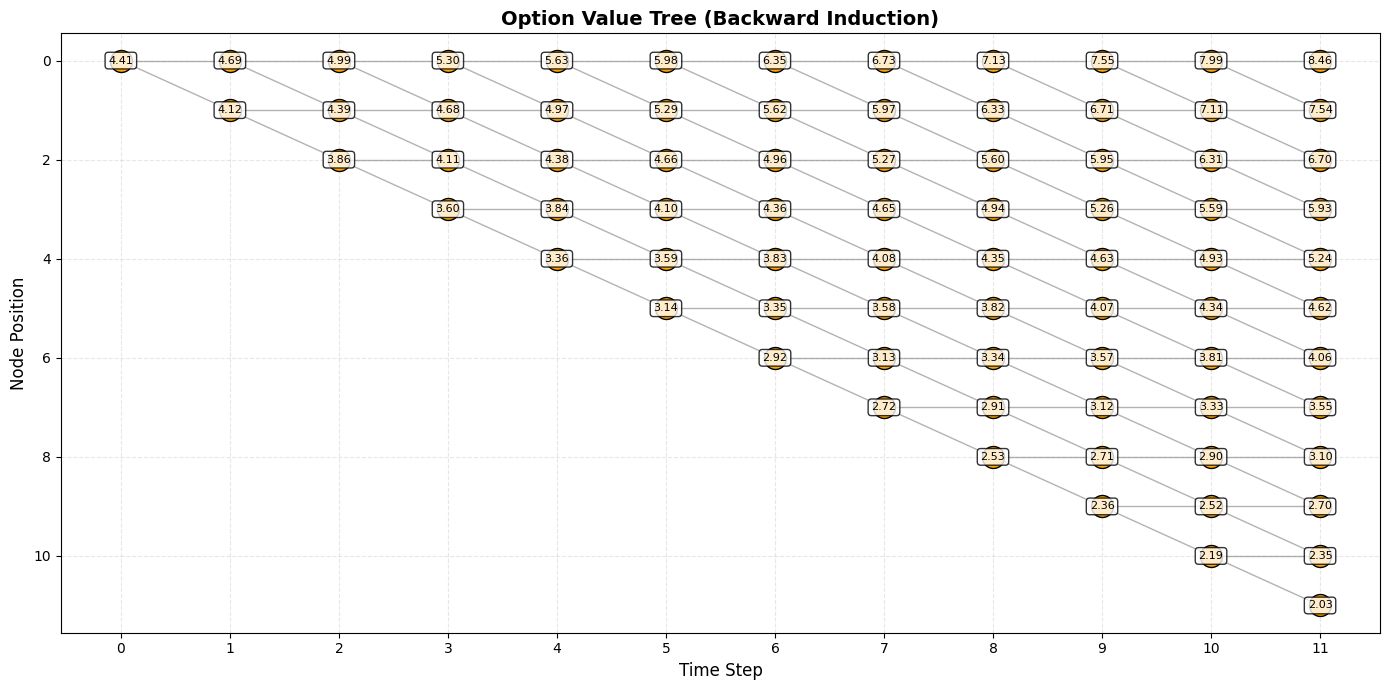

In [62]:
def plot_option_tree(tree, max_steps=11, node_color='orange', line_color='gray'):
    """
    Plots a binomial tree of option values.

    tree       : numpy array, option value tree (v_tree)
    max_steps  : maximum number of time steps to display
    node_color : color of the nodes
    line_color : color of the branches
    """
    N = min(tree.shape[1]-1, max_steps)

    plt.figure(figsize=(14, 7))

    # Calculate positions: use indices for y-coordinates instead of actual values
    # This prevents extreme scaling issues
    for i in range(N+1):
        for j in range(i+1):
            x = i
            # Use j as y-coordinate (node position in the tree)
            y = j

            # Get the actual option value for display
            value = tree[j, i]

            # Draw the node
            plt.scatter(x, y, s=250, color=node_color, edgecolor='black', zorder=3)

            # Write the value on the node
            plt.text(x, y, f"{value:.2f}", ha='center', va='center',
                    fontsize=8, zorder=4, bbox=dict(boxstyle='round,pad=0.3',
                    facecolor='white', alpha=0.8))

            # Draw branches to next step
            if i < N:
                # Up branch (same j)
                plt.plot([x, x+1], [y, j], color=line_color, lw=1, alpha=0.6)
                # Down branch (j+1)
                plt.plot([x, x+1], [y, j+1], color=line_color, lw=1, alpha=0.6)

    plt.title("Option Value Tree (Backward Induction)", fontsize=14, fontweight='bold')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Node Position", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(range(N+1))

    # Invert y-axis so the tree looks more natural (root at top)
    plt.gca().invert_yaxis()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# Use this function with your calculated value tree
s_tree, v_tree = tree_engine(s0, sigma, k, n, t, r, opttype=opttype, option_style=option_style)
plot_option_tree(v_tree, max_steps=11)

In [63]:
#call put parity check
def check_parity(s0, k, r, t, call_price, put_price, tol=1e-6):
    T = (t/252)
    lx=(call_price-put_price)
    dx=(s0-(k*(np.exp(-r*T))))
    diff=lx-dx

    if abs(diff) < tol:
        return True
    else:
        return False

In [64]:
if option_style == "eu":
    print('\n→ Option Style: European')
else:
    print('\n→ Option Style: American')

print()

print(f"Underlying Price    ${s0:>10.4f}")

if opttype == 'c':
    print(f"Option Type         {'Call':>10}")
    print(f"Strike Price        ${k:>10.4f}")
    print(f"Binomial Price      ${option_price_c:>10.4f}")
else:
    print(f"Option Type         {'Put':>10}")
    print(f"Strike Price        ${k:>10.4f}")
    print(f"Binomial Price      ${option_price_p:>10.4f}")

parity_check = check_parity(s0, k, r, t, option_price_c, option_price_p)

print()
if option_style == "eu":
    if parity_check:
        print("Put-Call Parity: Verified")
    else:
        print("Put-Call Parity: NOT Verified")
else:
    print("Put-Call Parity: N/A (American Option)")

print()


→ Option Style: American

Underlying Price    $  186.2300
Option Type               Call
Strike Price        $  242.0990
Binomial Price      $    4.4051

Put-Call Parity: N/A (American Option)

